In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Input, InputLayer, Dropout, Dense, Flatten, Embedding, Add, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop

import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

## Own code 
import import_ipynb
import metadata_options
import models_nn

importing Jupyter notebook from metadata_options.ipynb
importing Jupyter notebook from models_nn.ipynb


In [2]:
# Data with Throughput & WorkTime
df = pd.read_csv('./data/kokil dec 6 reprepare/conf_pc_worker_sem.csv')
df = df.dropna()

TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
Plot below: old throughput (x-axis) vs new throughput (y-axis)
WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)
TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)


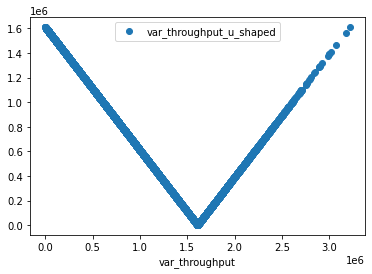

In [3]:
######################################
## Weighted Onehot Encoding options ##
######################################

##############
# Throughput #
##############
# TP1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP3 + k: weighted by 1 inverted k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TP4 + k: weighted by 1 upright k-power U-shaped variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# (For TP3 & TP4, k=1 results in V-shaped variance, and as k>1 increases, sides will curve into U-shaped variance)

############
# Worktime #
############
# WT1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# WT2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

################
# PC agreement #
################
# PC1: weighted by 1 average per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC2: weighted by 1 linear variance per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# PC3: weighted by 1 PC agreement weight per annotation in each OHE, i.e. (a, b, c, d) -> (w1*a, w2*b, w3*c, w4*d)

#####################
# Input text length #
#####################
# TL1: weighted by 1 normalised number of characters per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# TL2: weighted by 1 normalised number of words per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

###################
# Special Options #
###################
# SP1: weighted by average of TP1 and TP2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP2: weighted by average of WT1 and WT2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# SP3: weighted by average of PC1 and PC2 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_UNI: weighted by 1 uniformly distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)
# RAND_NORM: weighted by 1 normally distributed random number between 0 to 1 per set of OHE, i.e. (a, b, c, d) -> (w*a, w*b, w*c, w*d)

# Select 1 option from each of the few variants above, e.g. TP2, WT1, PC3, TL1, SP3, and input into function
# set_OHE_pipeline_options. If not selecting TP3 or TP4, input k (option_k) will be ignored. After
# editing the options, run the entire notebook for results accordingly.

# Edit option choices here
throughput_option = 'TP4'
worktime_option = 'WT2'
pc_agreement_option = 'PC3'
textlength_option = 'TL2'
special_option = 'RAND_UNI'
k_option_for_tp = 1

df_throughput, df_worktime, df_agreement, df_textlength, df_special = metadata_options.set_OHE_pipeline_options(df, throughput_option, worktime_option, pc_agreement_option, textlength_option, special_option, k_option_for_tp)

In [4]:
######################################
## Model Options ##
######################################
# options: lstm, cnn, lstm-attn

model_name = 'cnn'
models_nn.MODEL_NAME = model_name

In [5]:
df.head()

,Input.sentence_id,HITId,Input.convo_id,Input.train_test_val,Input.msg_id,Input.timestamp,Input.full_text,Input.speaker,Input.reply_to,Input.speaker_intention,...,prt,punct,purpcl,quantmod,rcmod,rel,root,tmod,xcomp,xsubj
5,11,3MG8450X2OASXZ0WO9O5AH70GU3UPA,Game1-italy-germany,Train,Game1-italy-germany-3,87,It seems like there are a lot of ways that cou...,germany-Game1,Game1-italy-germany-2,Truth,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,12,38G0E1M85M552JXSALX4G9WI2I6UVX,Game1-italy-germany,Train,Game1-italy-germany-7,117,"Sorry Italy I've been away doing, um, German t...",germany-Game1,Game1-italy-germany-6,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,14,3HYV4299H0WQ2B4TCS7PKDQ75WHE81,Game1-italy-germany,Train,Game1-italy-germany-8,119,"I don't think I'm ready to go for that idea, h...",germany-Game1,Game1-italy-germany-7,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
8,15,3XU9MCX6VOC4P079IHIO9TCNYLGR2P,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am pretty conflicted about whether to guess ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9,16,3FVBZG9CLJEK4WQS7P2GC1H2EEQH0Q,Game1-italy-germany,Train,Game1-italy-germany-9,121,I am going to take it literally and say even ...,italy-Game1,Game1-italy-germany-8,Truth,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0


In [6]:
# # Old train_test_split code
# train, test, indices_train, indices_test = train_test_split(df, indices, test_size=0.2)

# New train_test_split using Stratified Shaffled Splits
y = df["Input.deception_quadrant"].copy()
X = df.drop(["Input.deception_quadrant"], axis=1)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
splits_generator = sss.split(X, y)

for train_idx, test_idx in splits_generator:
    indices_train = train_idx
    indices_test = test_idx

train = df.take(indices_train)
test = df.take(indices_test)

In [7]:
print(df.shape, train.shape, test.shape)

(11366, 862) (9092, 862) (2274, 862)


In [8]:
# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

sklearn: 0.23.2


In [8]:
new_deception_train = train["Input.deception_quadrant"].copy()
new_deception_train['Input.deception_quadrant'] = train["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_train_deception = new_deception_train['Input.deception_quadrant'].to_numpy()
deception_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_deception),
                                                 y_train_deception)
deception_class_weight_dict = dict(enumerate(deception_class_weights))

y_train_rapport = train['Answer.3rapport.yes_label'].tolist()
rapport_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_rapport),
                                                 y_train_rapport)
rapport_class_weight_dict = dict(enumerate(rapport_class_weights))

y_train_share_information = train['Answer.4shareinformation.yes_label'].tolist()
share_info_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_share_information),
                                                 y_train_share_information)
share_info_class_weight_dict = dict(enumerate(share_info_class_weights))

y_train_reasoning = train['Answer.2reasoning.yes_label'].tolist()
reasoning_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_reasoning),
                                                 y_train_reasoning)
reasoning_class_weight_dict = dict(enumerate(reasoning_class_weights))

y_train_gamemove = train['Answer.1gamemove.yes_label'].tolist()
gamemove_class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_gamemove),
                                                 y_train_gamemove)
gamemove_class_weight_dict = dict(enumerate(gamemove_class_weights))

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0. 1.], y=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 

In [9]:
print("Class weights")
print("Deception: {} \nRapport: {} \nShare Information: {} \nReasoning: {} \nGamemove: {}".format(deception_class_weight_dict,
                                                                                                  rapport_class_weight_dict,
                                                                                                  share_info_class_weight_dict,
                                                                                                  reasoning_class_weight_dict,
                                                                                                  gamemove_class_weight_dict))

Class weights
Deception: {0: 10.192825112107624, 1: 0.525792273883877} 
Rapport: {0: 3.582348305752561, 1: 0.5811069922024799} 
Share Information: {0: 3.117969821673525, 1: 0.59549384333246} 
Reasoning: {0: 2.9596354166666665, 1: 0.6016410799364743} 
Gamemove: {0: 7.048062015503876, 1: 0.5381792352314431}


In [10]:
X_train_col = train['Input.full_text']

new_deception_test = test["Input.deception_quadrant"].copy()
new_deception_test['Input.deception_quadrant'] = test["Input.deception_quadrant"].apply(lambda x : 1 if x == "Straightforward" else 0)
y_test_deception = new_deception_test['Input.deception_quadrant'].tolist()
y_test_rapport = test['Answer.3rapport.yes_label'].tolist()
y_test_share_information = test['Answer.4shareinformation.yes_label'].tolist()
y_test_reasoning = test['Answer.2reasoning.yes_label'].tolist()
y_test_gamemove = test['Answer.1gamemove.yes_label'].tolist()

X_test_col = test['Input.full_text']

In [11]:
le = LabelEncoder()

# def label_preprocessing(y_data, label_encoder):
#     out = label_encoder.fit_transform(y_data).reshape(-1,1)
#     return out

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_train_rapport = le.fit_transform(y_train_rapport)
y_train_rapport = y_train_rapport.reshape(-1,1)

y_train_share_information = le.fit_transform(y_train_share_information)
y_train_share_information = y_train_share_information.reshape(-1,1)

y_train_reasoning = le.fit_transform(y_train_reasoning)
y_train_reasoning = y_train_reasoning.reshape(-1,1)

y_train_gamemove = le.fit_transform(y_train_gamemove)
y_train_gamemove = y_train_gamemove.reshape(-1,1)

y_train_deception = le.fit_transform(y_train_deception)
y_train_deception = y_train_deception.reshape(-1,1)

y_test_rapport = le.fit_transform(y_test_rapport)
y_test_rapport = y_test_rapport.reshape(-1,1)

y_test_share_information = le.fit_transform(y_test_share_information)
y_test_share_information = y_test_share_information.reshape(-1,1)

y_test_reasoning = le.fit_transform(y_test_reasoning)
y_test_reasoning = y_test_reasoning.reshape(-1,1)

y_test_gamemove = le.fit_transform(y_test_gamemove)
y_test_gamemove = y_test_gamemove.reshape(-1,1)

y_test_deception = le.fit_transform(y_test_deception)
y_test_deception = y_test_deception.reshape(-1,1)

y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

/home/kaiyuan/anaconda3/envs/TF2/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [12]:
max_words = 1000
max_len = 220

tok = Tokenizer(num_words=max_words)

tok.fit_on_texts(X_train_col)
X_train_sequences = tok.texts_to_sequences(X_train_col)
X_train = pad_sequences(X_train_sequences, maxlen=max_len)

X_test_sequences = tok.texts_to_sequences(X_test_col)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

### Construct individual  models

In [47]:
# Rapport model
rapport_model = models_nn.create_nn_model()
rapport_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                              models_nn.recall_m, models_nn.precision_m])
rapport_model.fit(X_train,y_train_rapport,
                  batch_size=128,
                  epochs=15,
                  validation_data=(X_test, y_test_rapport), 
                  callbacks=[models_nn.early_stop],
                  class_weight=rapport_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 1s 10ms/step - loss: 0.6942 - accuracy: 0.6628 - f1_m: 0.7428 - recall_m: 0.7274 - precision_m: 0.8645 - val_loss: 0.6548 - val_accuracy: 0.8712 - val_f1_m: 0.9305 - val_recall_m: 1.0000 - val_precision_m: 0.8704
Epoch 2/15
72/72 [==============================] - 1s 8ms/step - loss: 0.6921 - accuracy: 0.6709 - f1_m: 0.7800 - recall_m: 0.7360 - precision_m: 0.8699 - val_loss: 0.6452 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 0.9378 - val_precision_m: 0.8679
Epoch 3/15
72/72 [==============================] - 1s 8ms/step - loss: 0.6856 - accuracy: 0.6340 - f1_m: 0.7350 - recall_m: 0.6598 - precision_m: 0.8682 - val_loss: 0.6604 - val_accuracy: 0.6196 - val_f1_m: 0.7496 - val_recall_m: 0.6566 - val_precision_m: 0.8743


In [39]:
rapport_pred = rapport_model.predict(X_train)
rapport_pred_test = rapport_model.predict(X_test)

rapport_pred_test_round = rapport_pred_test.round()
precision_recall_fscore_support(y_test_rapport, rapport_pred_test_round, average='macro')

In [15]:
# Game move model
gamemove_model = models_nn.create_nn_model()
gamemove_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, 
                                                                               models_nn.recall_m, models_nn.precision_m])
gamemove_model.fit(X_train,
                   y_train_gamemove,
                   batch_size=128,
                   epochs=15,
                   validation_data=(X_test, y_test_gamemove), 
                   callbacks=[models_nn.early_stop],
                   class_weight=gamemove_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 1s 12ms/step - loss: 0.7021 - accuracy: 0.7039 - f1_m: 0.7539 - recall_m: 0.7418 - precision_m: 0.8431 - val_loss: 0.6643 - val_accuracy: 0.9376 - val_f1_m: 0.9675 - val_recall_m: 1.0000 - val_precision_m: 0.9372
Epoch 2/15
72/72 [==============================] - 1s 9ms/step - loss: 0.6733 - accuracy: 0.7582 - f1_m: 0.8392 - recall_m: 0.7950 - precision_m: 0.9365 - val_loss: 0.6538 - val_accuracy: 0.5207 - val_f1_m: 0.6678 - val_recall_m: 0.5167 - val_precision_m: 0.9482
Epoch 3/15
72/72 [==============================] - 1s 9ms/step - loss: 0.6722 - accuracy: 0.5342 - f1_m: 0.6693 - recall_m: 0.5284 - precision_m: 0.9488 - val_loss: 0.5700 - val_accuracy: 0.8558 - val_f1_m: 0.9213 - val_recall_m: 0.9056 - val_precision_m: 0.9380
Epoch 4/15
72/72 [==============================] - 1s 10ms/step - loss: 0.6592 - accuracy: 0.6375 - f1_m: 0.7569 - recall_m: 0.6411 - precision_m: 0.9561 - val_loss: 0.5295 - val_accuracy: 0.8188 - val_f1_m

In [16]:
gamemove_pred = gamemove_model.predict(X_train)
gamemove_pred_test = gamemove_model.predict(X_test)

gamemove_pred_test_round = gamemove_pred_test.round()
precision_recall_fscore_support(y_test_gamemove, gamemove_pred_test_round, average='macro')

(0.5179997871502448, 0.5765366117908199, 0.3892632959620249, None)

In [17]:
# Reasoning model
reasoning_model = models_nn.create_nn_model()
reasoning_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
reasoning_model.fit(X_train,
                    y_train_reasoning,
                    batch_size=128,
                    epochs=15,
                    validation_data=(X_test, y_test_reasoning), 
                    callbacks=[models_nn.early_stop],
                    class_weight=reasoning_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 1s 12ms/step - loss: 0.6988 - accuracy: 0.4486 - f1_m: 0.4327 - recall_m: 0.4255 - precision_m: 0.7103 - val_loss: 0.6967 - val_accuracy: 0.2823 - val_f1_m: 0.2567 - val_recall_m: 0.1517 - val_precision_m: 0.8631
Epoch 2/15
72/72 [==============================] - 1s 8ms/step - loss: 0.6933 - accuracy: 0.5536 - f1_m: 0.6556 - recall_m: 0.5759 - precision_m: 0.8408 - val_loss: 0.6488 - val_accuracy: 0.8219 - val_f1_m: 0.9011 - val_recall_m: 1.0000 - val_precision_m: 0.8212
Epoch 3/15
72/72 [==============================] - 1s 8ms/step - loss: 0.6779 - accuracy: 0.7179 - f1_m: 0.8035 - recall_m: 0.8014 - precision_m: 0.8553 - val_loss: 0.6753 - val_accuracy: 0.5365 - val_f1_m: 0.6549 - val_recall_m: 0.5379 - val_precision_m: 0.8404


In [18]:
reasoning_pred = reasoning_model.predict(X_train)
reasoning_pred_test = reasoning_model.predict(X_test)

reasoning_pred_test_round = reasoning_pred_test.round()
precision_recall_fscore_support(y_test_reasoning, reasoning_pred_test_round, average='macro')

(0.5206954226512504, 0.5352594970572498, 0.47324692997917417, None)

In [19]:
# Share Information model
shareinfo_model = models_nn.create_nn_model()
shareinfo_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
shareinfo_model.fit(X_train,
                    y_train_share_information,
                    batch_size=128,
                    epochs=15,
                    validation_data=(X_test, y_test_share_information), 
                    callbacks=[models_nn.early_stop],
                    class_weight=share_info_class_weight_dict)

Epoch 1/15
72/72 [==============================] - 2s 14ms/step - loss: 0.6907 - accuracy: 0.6212 - f1_m: 0.6723 - recall_m: 0.6727 - precision_m: 0.7984 - val_loss: 0.6998 - val_accuracy: 0.2089 - val_f1_m: 0.1339 - val_recall_m: 0.0732 - val_precision_m: 0.8952
Epoch 2/15
72/72 [==============================] - 1s 9ms/step - loss: 0.7002 - accuracy: 0.3691 - f1_m: 0.3801 - recall_m: 0.2906 - precision_m: 0.8707 - val_loss: 0.6973 - val_accuracy: 0.4222 - val_f1_m: 0.5233 - val_recall_m: 0.3780 - val_precision_m: 0.8594
Epoch 3/15
72/72 [==============================] - 1s 10ms/step - loss: 0.6836 - accuracy: 0.5382 - f1_m: 0.6396 - recall_m: 0.5253 - precision_m: 0.8810 - val_loss: 0.7553 - val_accuracy: 0.2463 - val_f1_m: 0.2217 - val_recall_m: 0.1279 - val_precision_m: 0.8640


In [20]:
shareinfo_pred = shareinfo_model.predict(X_train)
shareinfo_pred_test = shareinfo_model.predict(X_test)

shareinfo_pred_test_round = shareinfo_pred_test.round()
precision_recall_fscore_support(y_test_share_information, shareinfo_pred_test_round, average='macro')

(0.5104837568122301, 0.5087173375706214, 0.24554719002991768, None)

In [21]:
# Deception model
deception_model = models_nn.create_nn_model()
deception_model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy', models_nn.f1_m, models_nn.recall_m, models_nn.precision_m])
deception_model.fit(X_train,
                    y_train_deception,
                    epochs=15,
                    validation_data=(X_test, y_test_deception), 
                    callbacks=[models_nn.early_stop],
                    class_weight=deception_class_weight_dict)

Epoch 1/15
285/285 [==============================] - 3s 8ms/step - loss: 0.7375 - accuracy: 0.4901 - f1_m: 0.5162 - recall_m: 0.4880 - precision_m: 0.6535 - val_loss: 0.6458 - val_accuracy: 0.9507 - val_f1_m: 0.9747 - val_recall_m: 1.0000 - val_precision_m: 0.9514
Epoch 2/15
285/285 [==============================] - 2s 7ms/step - loss: 0.7006 - accuracy: 0.8218 - f1_m: 0.8895 - recall_m: 0.8563 - precision_m: 0.9525 - val_loss: 0.5996 - val_accuracy: 0.9481 - val_f1_m: 0.9733 - val_recall_m: 0.9967 - val_precision_m: 0.9516
Epoch 3/15
285/285 [==============================] - 2s 7ms/step - loss: 0.7019 - accuracy: 0.6454 - f1_m: 0.7489 - recall_m: 0.6549 - precision_m: 0.9577 - val_loss: 0.6983 - val_accuracy: 0.2093 - val_f1_m: 0.2884 - val_recall_m: 0.1744 - val_precision_m: 0.9316


In [22]:
deception_pred = deception_model.predict(X_train)
deception_pred_test = deception_model.predict(X_test)
deception_pred_test_round = deception_pred_test.round()
precision_recall_fscore_support(y_test_deception, deception_pred_test_round, average='macro')

(0.5012079027937237, 0.503753964583058, 0.19625097503900157, None)

### One hot encodings

In [23]:
# Train encodings
pred_df_arr_full = []
pred_df_arr = []
for i in range(0, len(gamemove_pred)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred[i][0]
    pred_obj_1['reasoning'] = reasoning_pred[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred[i][0]
    pred_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred[i][0]
    pred_df_arr_full.append(pred_obj_2)
    
pred_df_full = pd.DataFrame(pred_df_arr_full)
pred_df = pd.DataFrame(pred_df_arr)

In [24]:
# Test encodings
pred_test_df_arr_full = []
pred_test_df_arr = []

for i in range(0, len(gamemove_pred_test)):
    pred_obj_1 = {}
    pred_obj_1['gamemove'] = gamemove_pred_test[i][0]
    pred_obj_1['reasoning'] = reasoning_pred_test[i][0]
    pred_obj_1['shareinfo'] = shareinfo_pred_test[i][0]
    pred_test_df_arr.append(pred_obj_1)
    
    pred_obj_2 = pred_obj_1.copy()
    pred_obj_2['rapport'] = rapport_pred_test[i][0]
    pred_test_df_arr_full.append(pred_obj_2)
    
pred_test_df_full = pd.DataFrame(pred_test_df_arr_full)
pred_test_df = pd.DataFrame(pred_test_df_arr)

### Joint Model with one hot encoding 

In [25]:
print('Joint full model with one hot encoding, predicting deception')
joint_full_model = models_nn.create_joint_model(pred_df_full)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df_full,y_test_deception), 
                               callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 6ms/step - loss: 0.6925 - acc: 0.8646 - f1_m: 0.8839 - precision_m: 0.8617 - recall_m: 0.9077 - val_loss: 0.6918 - val_acc: 0.9507 - val_f1_m: 0.

In [26]:
joint_predict = joint_full_model.predict(pred_test_df_full)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [27]:
print('Joint full model with one hot encoding, predicting rapport')
joint_full_model = models_nn.create_joint_model(pred_df)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_test_df,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7044 - acc: 0.1347 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.7145 - val_acc: 0.1288 - 

In [28]:
joint_predict = joint_full_model.predict(pred_test_df)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## Weighted against Throughput, WorkTime, PC Agreement & Text Length

In [29]:
# Train weighted encodings
pred_df_full_throughput, pred_df_throughput, pred_df_full_worktime, pred_df_worktime, pred_df_full_agreement, pred_df_agreement, pred_df_full_textlength, pred_df_textlength, pred_df_full_special, pred_df_special = metadata_options.construct_weighted_dataframe(indices_train, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_df, pred_df_full)

In [30]:
# Test weighted encodings
pred_df_full_throughput_test, pred_df_throughput_test, pred_df_full_worktime_test, pred_df_worktime_test, pred_df_full_agreement_test, pred_df_agreement_test, pred_df_full_textlength_test, pred_df_textlength_test, pred_df_full_special_test, pred_df_special_test = metadata_options.construct_weighted_dataframe(indices_test, df_throughput, df_worktime, df_agreement, df_textlength, df_special, pred_test_df, pred_test_df_full)

## Throughput only

### Joint Model with one hot encoding 

In [31]:
print('Joint full model with one hot encoding, predicting deception, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_full_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_throughput, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_throughput_test,y_test_deception), 
                               callbacks=[models_nn.callback], 
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by throughput
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6766 - acc: 0.9185 - f1_m: 0.9423 - precision_m: 0.9540 - recall_m: 0.9639 - val_loss: 0.6898 - val_

In [32]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [33]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [34]:
print('Joint full model with one hot encoding, predicting rapport, weighted by throughput')
joint_full_model = models_nn.create_joint_model(pred_df_throughput)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_throughput, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_throughput_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by throughput
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6882 - acc: 0.8415 - f1_m: 0.9119 - precision_m: 0.8663 - recall_m: 0.9656 - val_loss: 0.6490 - val_ac

In [35]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## PC Agreement only

### Joint Model with one hot encoding 

In [36]:
print('Joint full model with one hot encoding, predicting deception, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_full_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_agreement, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_agreement_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by PC Agreement
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7011 - acc: 0.0819 - f1_m: 0.0627 - precision_m: 0.3143 - recall_m: 0.0359 - val_loss: 0.7073 - va

In [37]:
joint_predict = joint_full_model.predict(pred_df_full_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [38]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [39]:
print('Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement')
joint_full_model = models_nn.create_joint_model(pred_df_agreement)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_agreement, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_agreement_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by PC Agreement
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6898 - acc: 0.8545 - f1_m: 0.9201 - precision_m: 0.8651 - recall_m: 0.9856 - val_loss: 0.6832 - val_

In [40]:
joint_predict = joint_full_model.predict(pred_df_throughput_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## WorkTime only

### Joint Model with one hot encoding 

In [41]:
print('Joint full model with one hot encoding, predicting deception, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_full_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_worktime, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_worktime_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by worktime
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6792 - acc: 0.8651 - f1_m: 0.9095 - precision_m: 0.9154 - recall_m: 0.9047 - val_loss: 0.6917 - val_ac

In [42]:
joint_predict = joint_full_model.predict(pred_df_full_worktime_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [43]:
print('Joint full model with one hot encoding, predicting rapport, weighted by worktime')
joint_full_model = models_nn.create_joint_model(pred_df_worktime)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_worktime, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_worktime_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by worktime
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6973 - acc: 0.2032 - f1_m: 0.0861 - precision_m: 0.1141 - recall_m: 0.0840 - val_loss: 0.6956 - val_acc:

In [44]:
joint_predict = joint_full_model.predict(pred_df_worktime_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## Text Length only

### Joint Model with one hot encoding 

In [45]:
print('Joint full model with one hot encoding, predicting deception, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_full_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_textlength, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_textlength_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by text length
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6928 - acc: 0.8190 - f1_m: 0.8597 - precision_m: 0.9496 - recall_m: 0.8536 - val_loss: 0.6929 - val

In [46]:
joint_predict = joint_full_model.predict(pred_df_full_textlength_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [47]:
print('Joint full model with one hot encoding, predicting rapport, weighted by text length')
joint_full_model = models_nn.create_joint_model(pred_df_textlength)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_textlength, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_textlength_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by text length
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6920 - acc: 0.4647 - f1_m: 0.4961 - precision_m: 0.6964 - recall_m: 0.4648 - val_loss: 0.6914 - val_a

In [48]:
joint_predict = joint_full_model.predict(pred_df_textlength_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

## Other special options (either SP1, SP2, SP3, RAND_UNI, or RAND_NORM)

### Joint Model with one hot encoding 

In [49]:
print('Joint full model with one hot encoding, predicting deception, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_full_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_full_special, 
                               y=y_train_deception, 
                               epochs=32, 
                               batch_size=64, 
                               validation_data=(pred_df_full_special_test,y_test_deception), 
                               callbacks=[models_nn.callback],
                               class_weight=deception_class_weight_dict)

Joint full model with one hot encoding, predicting deception, weighted by special option
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 4)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.7043 - acc: 0.1195 - f1_m: 0.1249 - precision_m: 0.4140 - recall_m: 0.0775 - val_loss: 0.7119 -

In [50]:
joint_predict = joint_full_model.predict(pred_df_full_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_deception, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.024626209322779244, 0.5, 0.04694048616932104, None)

In [51]:
y_test_rapport = np.asarray(y_test_rapport)
y_train_rapport = np.asarray(y_train_rapport)

In [52]:
print('Joint full model with one hot encoding, predicting rapport, weighted by special option')
joint_full_model = models_nn.create_joint_model(pred_df_special)
joint_full_model.summary()
history = joint_full_model.fit(x=pred_df_special, 
                               y=y_train_rapport, 
                               epochs=32, 
                               batch_size=64,
                               validation_data=(pred_df_special_test,y_test_rapport), 
                               callbacks=[models_nn.callback], 
                               class_weight=rapport_class_weight_dict)

Joint full model with one hot encoding, predicting rapport, weighted by special option
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 12        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/32
143/143 [==============================] - 1s 5ms/step - loss: 0.6881 - acc: 0.8242 - f1_m: 0.8787 - precision_m: 0.8184 - recall_m: 0.9498 - val_loss: 0.6933 - v

In [53]:
joint_predict = joint_full_model.predict(pred_df_special_test)
joint_predict_round = []
for a in joint_predict:
    joint_predict_round.append(np.argmax(a))
precision_recall_fscore_support(y_test_rapport, np.array(joint_predict_round), average='macro')

C:\Users\adria\.conda\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.06442392260334213, 0.5, 0.11414102064666927, None)

In [54]:
1 in joint_predict_round

False